## Библиотеки для работы с временными рядами  
#### Prophet  
Библиотека Prophet использует аддитивную модель для прогнозирования временных рядов. Аддитивная модель предполагает, что значение временного ряда можно разложить на несколько компонент, таких как тренд, сезонность, праздничные эффекты и остатки.  
#### TSFRESH  
TSFRESH (Time Series Feature extraction based on Scalable Hypothesis tests) - это фреймворк в Python для извлечения признаков из временных рядов с целью подготовки данных для машинного обучения.  
#### ETNA  
Библиотека содержит в себе как классические модели прогнозирования, так и модели из других фреймворков:  
AutoArima, CatBoost, Holt-Winters, Linear Model, Moving Average, Naive Model, Neural Networks, Prophet, SARIMAX, Seasonal Moving Average, ARIMA, AutoARIMA, AutoETS

## Данные стоимости биткоина

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    TimeSeriesSplit
)

import warnings
warnings.filterwarnings('ignore')

Для загрузки воспользуемся библиотекой **yfinance**, которая предоставляет данные с Yahoo Finance.  
Пример работы с библиотекой  
https://github.com/FUlyankin/matstat-AB/blob/main/week15_timeseries/08_python_clusters.ipynb

In [2]:
# Указываем период времени c 18.08.23 по 03.09.23
start_date = datetime.datetime(2023, 8, 18, 0, 0, 0)
end_date = datetime.datetime(2023, 9, 3, 23, 55, 0)

# Загрузка данных
df = yf.download('BTC-USD', start=start_date, end=end_date, interval='5m')
print((df == 0).sum())
df.head()

[*********************100%%**********************]  1 of 1 completed
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume       2572
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-08-18 00:00:00+00:00,26636.078125,26643.093750,26604.636719,26643.093750,26643.093750,0
2023-08-18 00:05:00+00:00,26651.443359,26798.667969,26651.443359,26798.667969,26798.667969,0
2023-08-18 00:10:00+00:00,26783.312500,26808.195312,26779.664062,26779.664062,26779.664062,247603200
2023-08-18 00:15:00+00:00,26790.312500,26802.804688,26766.224609,26766.224609,26766.224609,0
2023-08-18 00:20:00+00:00,26740.546875,26781.376953,26740.546875,26764.076172,26764.076172,64237568


In [3]:
# Удалим столбцы Adj Close, Volume
df = df.drop(columns=["Adj Close", "Volume"])
df = df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low','Close': 'close'})

Загрузка данных c интервалом 5 мин возможна за последние 60 дней, поэтому сохраним данные в файл, чтобы иметь к нему доступ впоследствии

In [4]:
# df.to_csv("data/BTC_5min_yfinance.csv")

Далее будем работать с этим файлом

In [2]:
df = pd.read_csv("data/BTC_5min_yfinance.csv",
                   parse_dates=True,
                   index_col='Datetime'
                  )
df

,open,high,low,close
Datetime,,,,
2023-08-18 00:00:00+00:00,26636.078125,26643.093750,26604.636719,26643.093750
2023-08-18 00:05:00+00:00,26651.443359,26798.667969,26651.443359,26798.667969
2023-08-18 00:10:00+00:00,26783.312500,26808.195312,26779.664062,26779.664062
2023-08-18 00:15:00+00:00,26790.312500,26802.804688,26766.224609,26766.224609
2023-08-18 00:20:00+00:00,26740.546875,26781.376953,26740.546875,26764.076172
...,...,...,...,...
2023-09-03 23:30:00+00:00,25957.468750,25957.892578,25956.755859,25956.755859
2023-09-03 23:35:00+00:00,25956.775391,25956.775391,25952.150391,25952.150391
2023-09-03 23:40:00+00:00,25952.716797,25962.248047,25952.369141,25962.248047


Будем прогнозировать стоимость биткоина на момент открытия торгов (open).

In [6]:
data = df[['open']]
df.isna().sum()

open     0
high     0
low      0
close    0
dtype: int64

<AxesSubplot: xlabel='Datetime'>

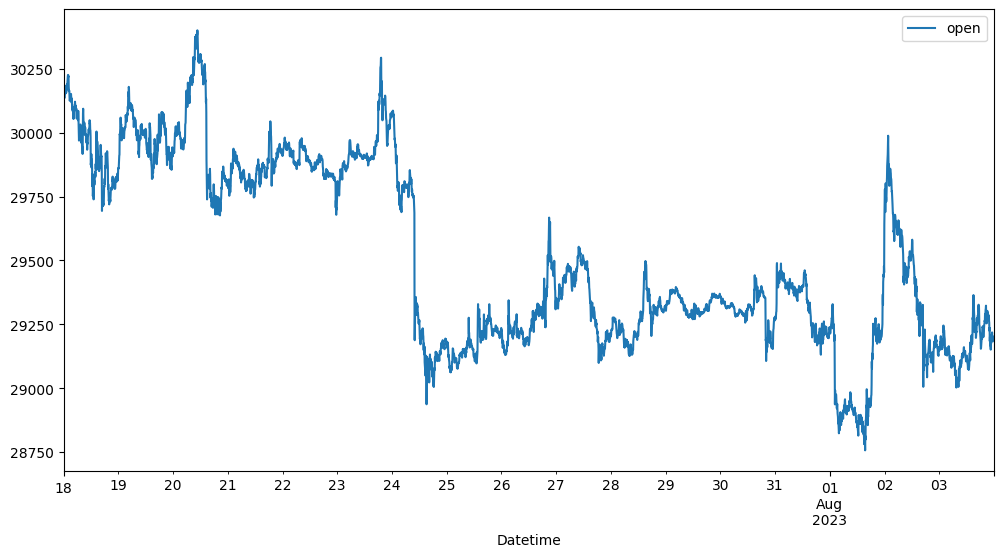

In [17]:
data.plot(figsize=(12,6))

## Модели Sklearn

In [7]:
def run_model(model, X_train, y_train):
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(preds, "r", label="prediction")
    plt.plot(y_test.values, label="actual")
    plt.grid(True)
    plt.legend(loc="best")
    plt.title(f"{type(model).__name__}\n Mean absolute error {mean_absolute_error(preds, y_test)}")
    
    return model

Добавляем лаги исходного ряда в качестве признаков

In [8]:
lag_start = 5
lag_end = 20

for i in range(lag_start, lag_end):
    data[f"lag_{i}"] = data['open'].shift(i)

data.dropna(inplace=True)
data.head()

,open,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
Datetime,,,,,,,,,,,,,,,,
2023-08-18 01:35:00+00:00,26592.312500,26669.912109,26695.199219,26745.818359,26673.736328,26668.310547,26698.515625,26722.869141,26682.689453,26733.271484,26753.410156,26740.546875,26790.312500,26783.312500,26651.443359,26636.078125
2023-08-18 01:40:00+00:00,26594.130859,26603.001953,26669.912109,26695.199219,26745.818359,26673.736328,26668.310547,26698.515625,26722.869141,26682.689453,26733.271484,26753.410156,26740.546875,26790.312500,26783.312500,26651.443359
2023-08-18 01:45:00+00:00,26642.326172,26594.685547,26603.001953,26669.912109,26695.199219,26745.818359,26673.736328,26668.310547,26698.515625,26722.869141,26682.689453,26733.271484,26753.410156,26740.546875,26790.312500,26783.312500
2023-08-18 01:50:00+00:00,26587.630859,26620.748047,26594.685547,26603.001953,26669.912109,26695.199219,26745.818359,26673.736328,26668.310547,26698.515625,26722.869141,26682.689453,26733.271484,26753.410156,26740.546875,26790.312500
2023-08-18 01:55:00+00:00,26572.380859,26606.626953,26620.748047,26594.685547,26603.001953,26669.912109,26695.199219,26745.818359,26673.736328,26668.310547,26698.515625,26722.869141,26682.689453,26733.271484,26753.410156,26740.546875


Разделение на train и test  
Извлечение агрегированных признаков (средняя стоимость за день, час)

In [9]:
data["hour"] = data.index.hour
data["dayofweek"] = data.index.dayofweek

In [10]:
X_train, X_test = train_test_split(data, test_size=0.15, shuffle=False)

In [11]:
# Monday=0
X_train.groupby("dayofweek")["open"].mean()

dayofweek
0    26045.025987
1    26335.652919
2    26762.885451
3    26580.599809
4    26128.371273
5    26018.204234
6    26093.525689
Name: open, dtype: float64

In [12]:
# считаем средние только по X_train, чтобы избежать data leak
data["hourly_average"] = data["hour"].map(X_train.groupby("hour")["open"].mean())
data["daily_average"] = data["dayofweek"].map(X_train.groupby("dayofweek")["open"].mean())

In [13]:
# выкидываем закодированные средними признаки
data.drop(["hour"], axis=1, inplace=True)
data.drop(["dayofweek"], axis=1, inplace=True)

In [14]:
data.isna().sum().sum()

0

In [15]:
data.columns

Index(['open', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'hourly_average', 'daily_average'],
      dtype='object')

In [16]:
# заново разделяем агрегированный датасет
X_train, X_test = train_test_split(data, test_size=0.15, shuffle=False)

Разделение на X и y

In [17]:
y_train = X_train.pop('open')
y_test = X_test.pop('open')

In [18]:
X_train.shape, X_test.shape

((4142, 17), (732, 17))

#### Линейная регрессия

LinearRegression()

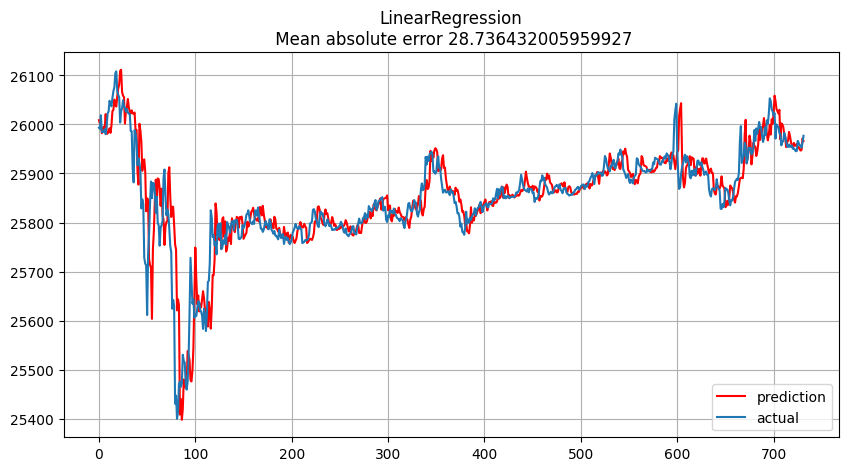

In [19]:
from sklearn.linear_model import LinearRegression

run_model(LinearRegression(), X_train, y_train)

Попробуем улучшить точность модели.  
Добавим недывние лаги, так как прогнозируем на один момент вперед (5 минут). Подбирать лучшие лаги можно **перебором!!!**  
Добавим скользящее среднее за час (12 значений в часе) и за день (12 * 24 = 288).

In [20]:
data = df[['open']]

lag_start = 1
lag_end = 20

for i in range(lag_start, lag_end):
    data[f"lag_{i}"] = data['open'].shift(i)
data.dropna(inplace=True)

data['hourly_roll'] = data['open'].rolling(window=12).mean().shift(1)
data['daily_roll'] = data['open'].rolling(window=288).mean().shift(1)
data.dropna(inplace=True)

data["hour"] = data.index.hour
data["dayofweek"] = data.index.dayofweek

X_train, X_test = train_test_split(data, test_size=0.15, shuffle=False)

data["hourly_average"] = data["hour"].map(X_train.groupby("hour")["open"].mean())
data["daily_average"] = data["dayofweek"].map(X_train.groupby("dayofweek")["open"].mean())
data.drop(["hour"], axis=1, inplace=True)
data.drop(["dayofweek"], axis=1, inplace=True)

X_train, X_test = train_test_split(data, test_size=0.15, shuffle=False)

y_train = X_train.pop('open')
y_test = X_test.pop('open')

LinearRegression()

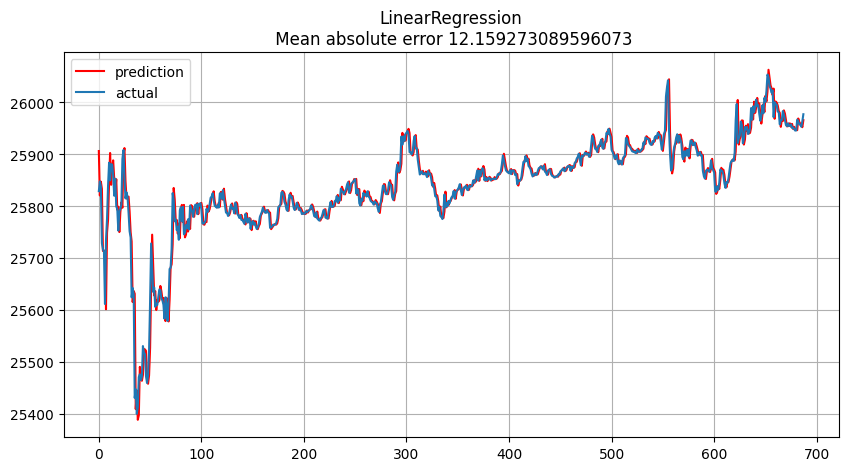

In [21]:
run_model(LinearRegression(), X_train, y_train)

Посмотрим на важность признаков и какие-то уже выбросим

In [22]:
data.corrwith(data['open'])

open              1.000000
lag_1             0.998642
lag_2             0.997030
lag_3             0.995261
lag_4             0.993402
lag_5             0.991511
lag_6             0.989740
lag_7             0.987931
lag_8             0.986036
lag_9             0.984153
lag_10            0.982199
lag_11            0.980241
lag_12            0.978280
lag_13            0.976321
lag_14            0.974318
lag_15            0.972292
lag_16            0.970245
lag_17            0.968334
lag_18            0.966425
lag_19            0.964533
hourly_roll       0.992018
daily_roll        0.763609
hourly_average    0.040434
daily_average     0.608264
dtype: float64

Коэффициент Пирсона говорит о слабом влиянии среднего за час (hourly_average)

In [23]:
# Добавляем столбец x0=1, соответствующий константе w0, так как в библиотеке sm константа не предусмотрена
X_train = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train).fit()

In [24]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   open   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 6.613e+04
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        00:41:38   Log-Likelihood:                -18149.
No. Observations:                3898   AIC:                         3.634e+04
Df Residuals:                    3875   BIC:                         3.649e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -34.5527    284.571     -0.121      0.903    -592.475     523.370
lag_1              1.0875      0.016     67.708      0.000       1.056       1.119
lag_2             -0.0487      0.024     -2.046      0.041      -0.095      -0.002
lag_3             -0.0442      0.024     -1.859      0.063      -0.091       0.002
lag_4              0.0046      0.024      0.193      0.847      -0.042       0.051
lag_5             -0.0883      0.024     -3.712      0.000      -0.135      -0.042
lag_6              0.0661      0.024      2.777      0.006       0.019       0.113
lag_7              0.0173      0.024      0.725      0.468      -0.029       0.064
lag_8             -0.0591      0.024     -2.472      0.013      -0.106      -0.012
lag_9              0.0364      0.024      1.519      0.129      -0.011       0.083
lag_10            -0.0448      0.024     -1.872      0.061      -0.092       0.002
lag_11            -0.0135      0.024     -0.565      0.572      -0.060       0.033
lag_12             0.0158      0.024      0.663      0.507      -0.031       0.063
lag_13             0.0138      0.024      0.578      0.563      -0.033       0.061
lag_14            -0.0182      0.024     -0.763      0.445      -0.065       0.029
lag_15             0.0041      0.024      0.173      0.862      -0.043       0.051
lag_16            -0.0666      0.024     -2.792      0.005      -0.113      -0.020
lag_17             0.0698      0.024      2.925      0.003       0.023       0.117
lag_18            -0.0098      0.024     -0.410      0.682      -0.057       0.037
lag_19             0.0003      0.016      0.018      0.985      -0.031       0.032
hourly_roll        0.0774      0.001     62.082      0.000       0.075       0.080
daily_roll        -0.0030      0.002     -1.862      0.063      -0.006       0.000
hourly_average     0.0029      0.011      0.274      0.784      -0.018       0.024
daily_average      0.0015      0.002      0.801      0.423      -0.002       0.005
==============================================================================
Omnibus:                     3700.751   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1424614.717
Skew:                           3.766   Prob(JB):                         0.00
Kurtosis:                      96.352   Cond. No.                     2.24e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.23e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Анализ значимости коэффициентов регрессии указывает на значимость признаков:  
лаги 1, 2, 3(?), 5, 6, 8, 16, 17, почасовое скользящее среднее (hourly_roll)

In [25]:
# Удаляем столбец X_train['const']
X_train = X_train.drop(columns=['const'])

#### Случайный лес  

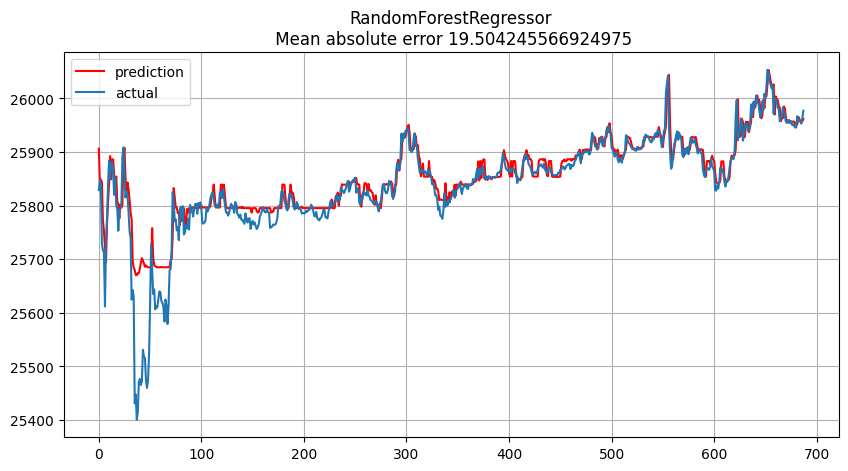

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf = run_model(RandomForestRegressor(max_depth=6), X_train, y_train)

#### Градиентный бустинг

GradientBoostingRegressor(max_depth=2)

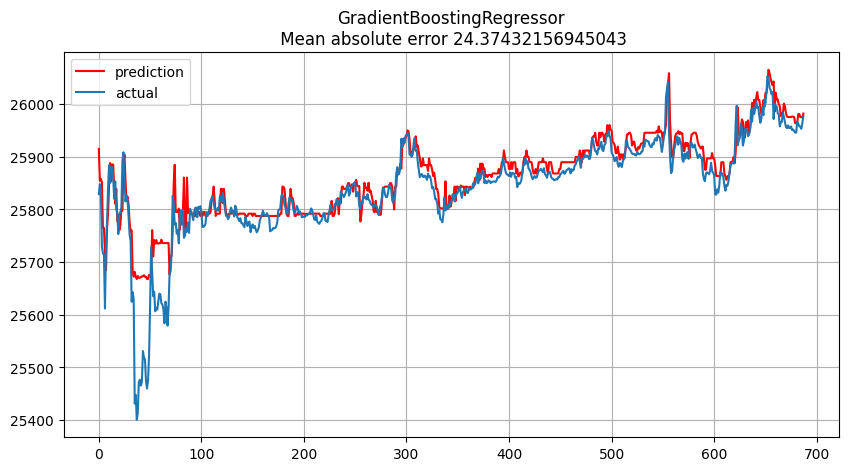

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

run_model(GradientBoostingRegressor(max_depth=2), X_train, y_train)

In [42]:
pd.DataFrame(rf.feature_importances_, index=list(X_train),
             columns=['Importance']).sort_values(by='Importance').tail(7)

,Importance
lag_5,0.000135
lag_4,0.000528
daily_roll,0.001062
hourly_roll,0.001370
lag_3,0.010670
lag_2,0.085257
lag_1,0.900385


#### Лучшая модель sklearn - линейная регрессия  
С помощью Random Forest оценили, что наиболее важные признаки - первые лаги.  
Выбросим признаки hourly_average, daily_average. Оставим только лаги 1 - 10 и 16, 17. Лучше всего сработала линейная регрессия, поэтому посмотрим, какая будет точность на отобранных признаках.

In [43]:
def make_lag(columns, lag_start, lag_end):
    
    for i in range(lag_start, lag_end):
        for column in columns:
            data[f"{column}_lag_{i}"] = data[column].shift(i)
    data.dropna(inplace=True)
    
    return data

In [47]:
data = df[['open']]
columns = data.columns

data = make_lag(columns, lag_start=1, lag_end=11)
data = make_lag(columns, lag_start=16, lag_end=18)

data['hourly_roll'] = data['open'].rolling(window=12).mean().shift(1)
data['daily_roll'] = data['open'].rolling(window=288).mean().shift(1)
data.dropna(inplace=True)

X = data.copy()
y = X.pop('open')

lr = LinearRegression()
# Добавим кросс-валидацию
scores = cross_val_score(lr, X, y, cv=TimeSeriesSplit(test_size = len(X) // 15), scoring='neg_mean_absolute_error')
print('Mean absolute error ', -scores.mean())

Mean absolute error  15.82569099690806


In [48]:
scores

array([-21.92380288, -18.55574365, -20.42780557,  -8.91908992,
        -9.30201296])

Попробуем прогнозировать, используя не только цену открытия, но и другие котировки (close...)

In [49]:
def run_lr():
    
    # Удаляем high, low, close в текущий момент
    y = data['open']
    X = data.drop(columns=columns)
    
    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv=TimeSeriesSplit(test_size = len(X) // 15), scoring='neg_mean_absolute_error')
    print('Mean absolute error ', -scores.mean())

In [51]:
data = df.copy()
columns = data.columns

# лаги по open, high, low, close
data = make_lag(columns, lag_start=1, lag_end=11)
data = make_lag(columns, lag_start=16, lag_end=18)

# скользящие окна
data['hourly_roll'] = data['open'].rolling(window=12).mean().shift(1)
data['daily_roll'] = data['open'].rolling(window=288).mean().shift(1)
data.dropna(inplace=True)

run_lr()

Mean absolute error  5.9454720361863505


In [52]:
# Добавим скользщие окна по другим столбцам

data = df.copy()
columns = data.columns

data = make_lag(columns, lag_start=1, lag_end=11)
data = make_lag(columns, lag_start=16, lag_end=18)

for column in columns:
    data[f"{column}_hourly_roll"] = data[column].rolling(window=12).mean().shift(1)
    data[f"{column}_daily_roll"] = data[column].rolling(window=288).mean().shift(1)
data.dropna(inplace=True)

run_lr()

Mean absolute error  5.995341826818788


Если прогнозировать не только по цене открытия, а по всем типам цен, то точность улучшается с 12 до 6. Однако добавление скользящих средних по всем ценам не улучшает прогноз.

#### Дополнительные данные в качестве экзогенных фактров  
- индекс Доу-Джонса  
- индекс S&P500  
- курс ethereum

In [53]:
# Тикеры для Ethereum, Dow Jones и S&P 500
tickers = ['ETH-USD', '^DJI', '^GSPC']

exog_full = yf.download(tickers, start=start_date, end=end_date, interval='5m')
exog_full

[*********************100%%**********************]  3 of 3 completed


Adj Close                   Close             \
                               ETH-USD ^DJI ^GSPC      ETH-USD ^DJI ^GSPC   
Datetime                                                                    
2023-08-18 00:00:00+00:00  1683.702881  NaN   NaN  1683.702881  NaN   NaN   
2023-08-18 00:05:00+00:00  1694.453491  NaN   NaN  1694.453491  NaN   NaN   
2023-08-18 00:10:00+00:00  1694.606323  NaN   NaN  1694.606323  NaN   NaN   
2023-08-18 00:15:00+00:00  1695.813843  NaN   NaN  1695.813843  NaN   NaN   
2023-08-18 00:20:00+00:00  1696.927124  NaN   NaN  1696.927124  NaN   NaN   
...                                ...  ...   ...          ...  ...   ...   
2023-09-03 23:30:00+00:00  1635.180664  NaN   NaN  1635.180664  NaN   NaN   
2023-09-03 23:35:00+00:00  1635.268677  NaN   NaN  1635.268677  NaN   NaN   
2023-09-03 23:40:00+00:00  1635.960815  NaN   NaN  1635.960815  NaN   NaN   
2023-09-03 23:45:00+00:00  1636.748291  NaN   NaN  1636.748291  NaN   NaN   
2023-09-03 23:50:00+00:00  1635.922241  NaN   NaN  1635.922241  NaN   NaN   

                                  High                     Low             \
                               ETH-USD ^DJI ^GSPC      ETH-USD ^DJI ^GSPC   
Datetime                                                                    
2023-08-18 00:00:00+00:00  1683.702881  NaN   NaN  1680.296387  NaN   NaN   
2023-08-18 00:05:00+00:00  1694.453491  NaN   NaN  1687.053955  NaN   NaN   
2023-08-18 00:10:00+00:00  1695.588745  NaN   NaN  1693.589111  NaN   NaN   
2023-08-18 00:15:00+00:00  1697.365112  NaN   NaN  1695.813843  NaN   NaN   
2023-08-18 00:20:00+00:00  1698.032471  NaN   NaN  1693.752563  NaN   NaN   
...                                ...  ...   ...          ...  ...   ...   
2023-09-03 23:30:00+00:00  1635.296631  NaN   NaN  1635.107178  NaN   NaN   
2023-09-03 23:35:00+00:00  1635.268677  NaN   NaN  1635.205444  NaN   NaN   
2023-09-03 23:40:00+00:00  1635.960815  NaN   NaN  1635.253174  NaN   NaN   
2023-09-03 23:45:00+00:00  1636.930176  NaN   NaN  1636.284302  NaN   NaN   
2023-09-03 23:50:00+00:00  1636.706299  NaN   NaN  1635.922241  NaN   NaN   

                                  Open                Volume             
                               ETH-USD ^DJI ^GSPC    ETH-USD ^DJI ^GSPC  
Datetime                                                                 
2023-08-18 00:00:00+00:00  1682.038452  NaN   NaN          0  NaN   NaN  
2023-08-18 00:05:00+00:00  1687.053955  NaN   NaN          0  NaN   NaN  
2023-08-18 00:10:00+00:00  1693.589111  NaN   NaN  211423232  NaN   NaN  
2023-08-18 00:15:00+00:00  1696.985474  NaN   NaN          0  NaN   NaN  
2023-08-18 00:20:00+00:00  1693.752563  NaN   NaN   45827072  NaN   NaN  
...                                ...  ...   ...        ...  ...   ...  
2023-09-03 23:30:00+00:00  1635.296631  NaN   NaN    1897728  NaN   NaN  
2023-09-03 23:35:00+00:00  1635.205444  NaN   NaN    1497856  NaN   NaN  
2023-09-03 23:40:00+00:00  1635.305542  NaN   NaN          0  NaN   NaN  
2023-09-03 23:45:00+00:00  1636.284302  NaN   NaN    2561536  NaN   NaN  
2023-09-03 23:50:00+00:00  1636.706299  NaN   NaN          0  NaN   NaN  

[4893 rows x 18 columns]

По индексам Доу-Джонса и S&P500 есть только дневные данные, поэтому оставим только курс эфириума (цены открытия и закрытия).

In [54]:
exog = exog_full[['Open', 'Close']]
exog = exog.drop(columns=["^DJI", "^GSPC"], level=1)

# Избавляемся от мультииндексов в столбцах
exog.columns = exog.columns.droplevel(1)
exog = exog.rename(columns={'Open': 'ETH_open', 'Close': 'ETH_close'})

# Сохраняем в файл
# exog.to_csv("data/ETH_5min_yfinance.csv")

,ETH_open,ETH_close
Datetime,,
2023-08-18 00:00:00+00:00,1682.038452,1683.702881
2023-08-18 00:05:00+00:00,1687.053955,1694.453491
2023-08-18 00:10:00+00:00,1693.589111,1694.606323
2023-08-18 00:15:00+00:00,1696.985474,1695.813843
2023-08-18 00:20:00+00:00,1693.752563,1696.927124


In [55]:
exog = pd.read_csv("data/ETH_5min_yfinance.csv",
                   parse_dates=True,
                   index_col='Datetime'
                  )
exog.head()

,ETH_open,ETH_close
Datetime,,
2023-08-18 00:00:00+00:00,1682.038452,1683.702881
2023-08-18 00:05:00+00:00,1687.053955,1694.453491
2023-08-18 00:10:00+00:00,1693.589111,1694.606323
2023-08-18 00:15:00+00:00,1696.985474,1695.813843
2023-08-18 00:20:00+00:00,1693.752563,1696.927124


In [56]:
'нулевые значения', (exog == 0).sum(), 'пропуски', exog.isna().sum()

('нулевые значения',
 ETH_open     0
 ETH_close    0
 dtype: int64,
 'пропуски',
 ETH_open     0
 ETH_close    0
 dtype: int64)

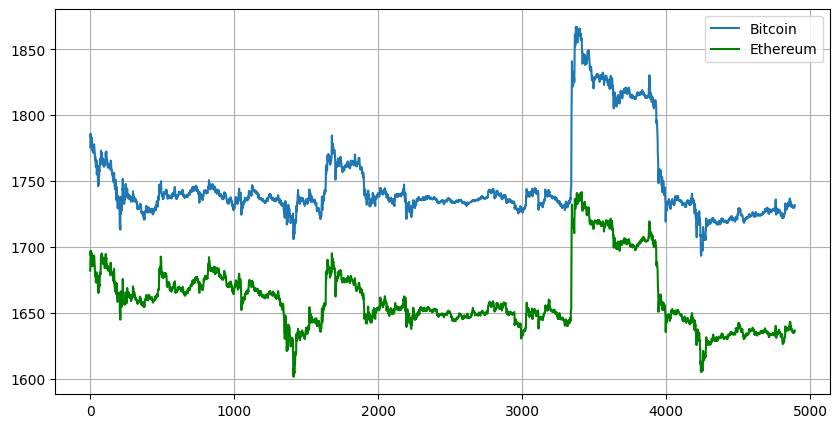

In [74]:
# Объединяем
data = df.join(exog)

# Сравнение в относительной шкале
plt.figure(figsize=(10, 5))
plt.plot((data['open'] / 15).values, label="Bitcoin")
plt.plot(data['ETH_open'].values, "g", label="Ethereum")
plt.grid(True)
plt.legend(loc="best")

In [84]:
data = df.join(exog)
columns = data.columns

data = make_lag(columns, lag_start=1, lag_end=11)
data = make_lag(columns, lag_start=16, lag_end=18)

data['hourly_roll'] = data['open'].rolling(window=12).mean().shift(1)
data['daily_roll'] = data['open'].rolling(window=288).mean().shift(1)
data.dropna(inplace=True)

run_lr()

Mean absolute error  6.111671371828459


Учет цены Ethereum не помог улучшить прогноз

## Модели семейства ARMA

In [30]:
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

<Figure size 640x480 with 0 Axes>

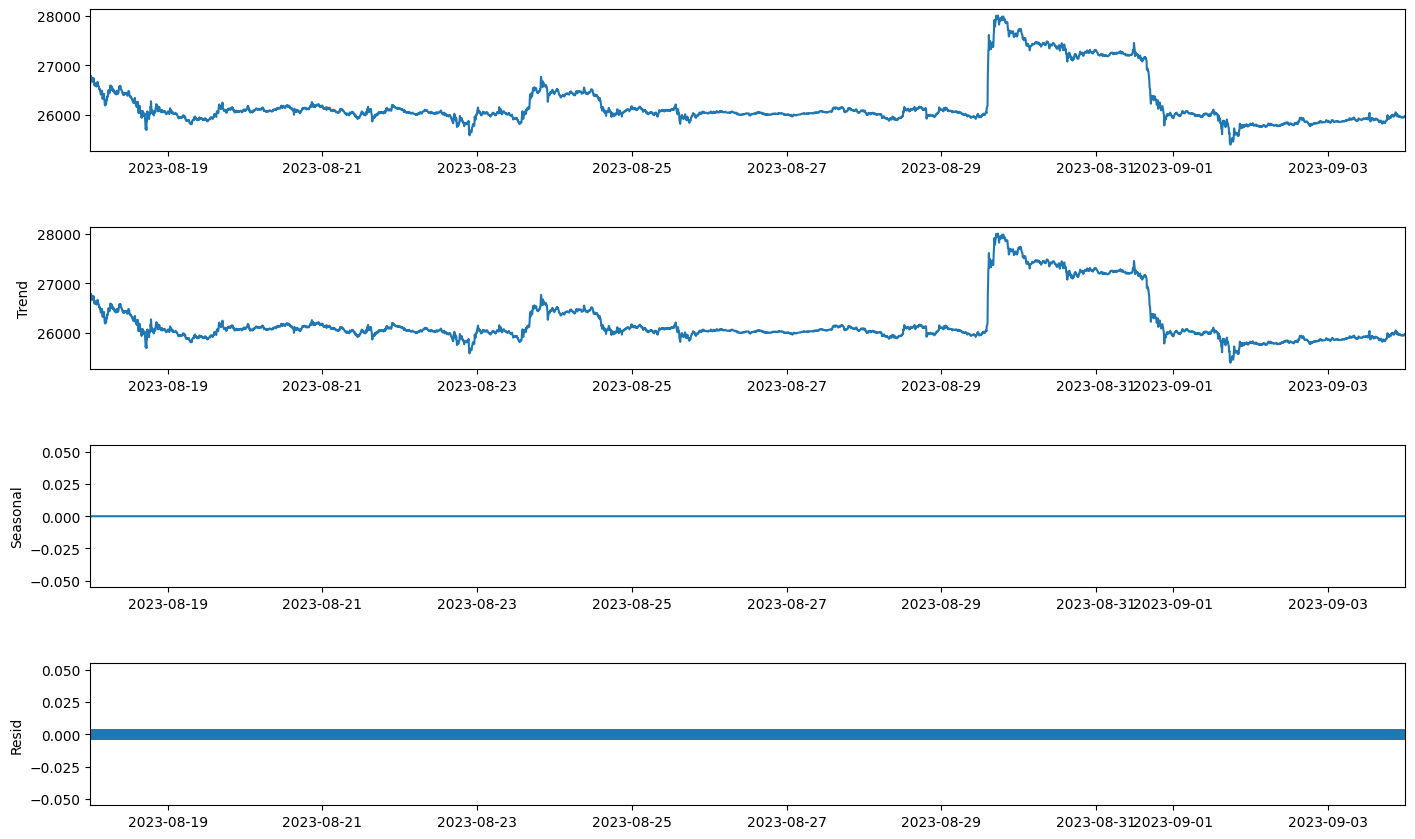

In [4]:
data = df[['open']]

# Раскладываем ряд на компоненты
decompose = seasonal_decompose(data, period = 1)
fig = plt.figure()  
fig = decompose.plot()  
fig.set_size_inches(16, 9)

### Подбор параметров для ARIMA  
Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка.  

#### Проверка на стационарность  
- **Тест Дики-Фуллера**  
Нулевая гипотеза H<sub>0</sub>: ряд не стационарен  
- **Тест KPSS (Kwiatkowski–Phillips–Schmidt–Shin test)**  
Нулевая гипотеза H<sub>0</sub>: ряд стационарен  
  
Тесты можно проводить против разных альтернатив, в зависимости от того, что мы видим в данных:  
-"c" : constant only (default).  
-"ct" : constant and trend.  
-"ctt" : constant, and linear and quadratic trend.  
-"nc" : no constant, no trend.  
  
По-видимому, в наших данных есть тренд и константа, так как ряд колеблется вокруг ненулевого среднего.

In [18]:
print("Критерий Дики-Фуллера: p=%f" % adfuller(data, regression='ct')[1])
print("Критерий KPSS: p=%f" % kpss(data, regression='ct')[1])

Критерий Дики-Фуллера: p=0.138893
Критерий KPSS: p=0.010000


Нет достаточных оснований отвергнуть гипотезу о нестационарности ряда, так как Тест Дики-Фуллера не отвергает эту гипотезу, а p-value KPSS-теста находится на критическом уровне 0,01.

#### Способы избавления от нестационарности  
- разности различного порядка,  
- выделение тренда и сезонности,  
- сглаживание,  
- преобразование Бокса-Кокса,  
- логарифмирование

Критерий Дики-Фуллера: p=0.000000
Критерий KPSS: p=0.100000


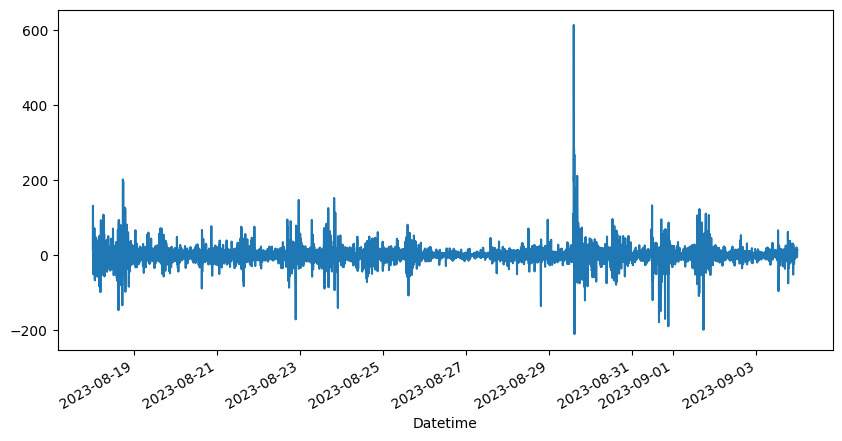

In [5]:
# Дифференцирование

data['1difference'] = data['open'] - data['open'].shift(1)
data['1difference'].plot(figsize=(10,5))

print("Критерий Дики-Фуллера: p=%f" % adfuller(data['1difference'].dropna(), regression='ct')[1])
print("Критерий KPSS: p=%f" % kpss(data['1difference'].dropna(), regression='ct')[1])

Согласно критериям ряд стал стационарным, но визуально в данных видны всплески в некоторых местах. Попробуем добавить ещё одно дифференцирование.

Критерий Дики-Фуллера: p=0.000000
Критерий KPSS: p=0.100000


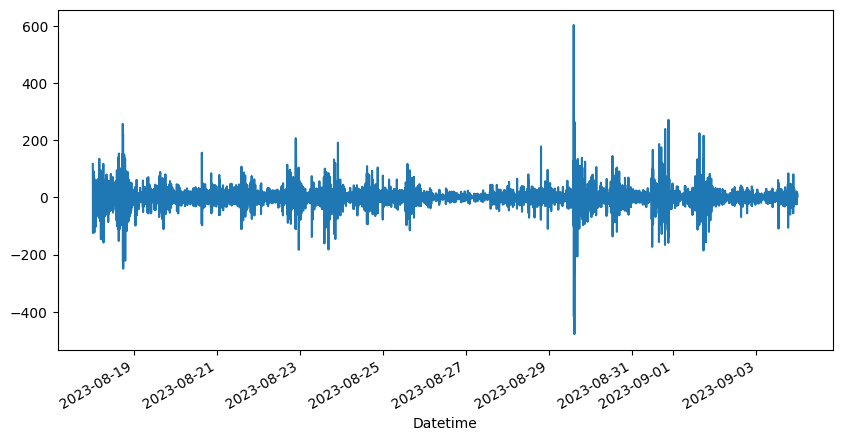

In [6]:
data['2difference'] = data['1difference'] - data['1difference'].shift(1)
data['2difference'].plot(figsize=(10,5))

print("Критерий Дики-Фуллера: p=%f" % adfuller(data['2difference'].dropna(), regression='ct')[1])
print("Критерий KPSS: p=%f" % kpss(data['2difference'].dropna(), regression='ct')[1])

График остался без изменений после второго дифференцирования, поэтому будем полагать, что у нас ряд первого порядка (d = 1).

Проанализируем графики автокорреляций

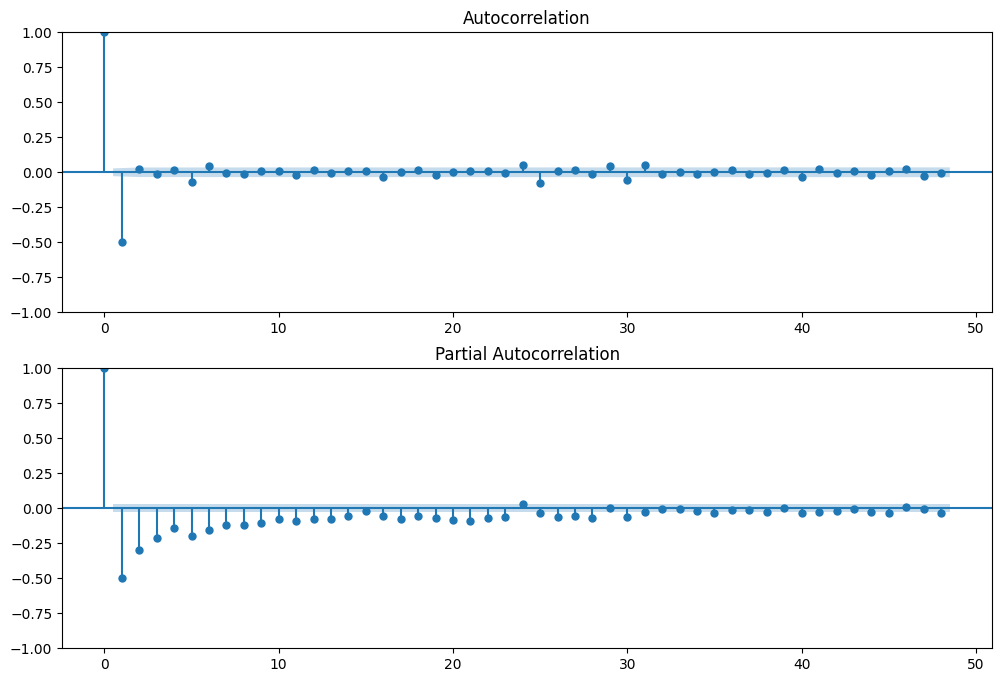

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['2difference'].dropna(),lags=48,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['2difference'].dropna(),lags=48,ax=ax2)

Автокорреляция, кроме первого лага, слабая. Мы не можем выявить четкой сезонности и тренда.

**p** - определяется с помощью PACF, по коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR  
**d** - порядок интегрированного ряда  
**q** - определяется с помощью ACF, по коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA  
**D** - порядок интегрированности сезонной разности  

Начальные приближения:
q=1, d=1, p=1

### SARIMAX с выбранными параметрами

In [9]:
train, test = train_test_split(data['open'], test_size=0.15, shuffle=False)

arima = SARIMAX(train, order = (1, 1, 1))    # p,d,q
result = arima.fit()

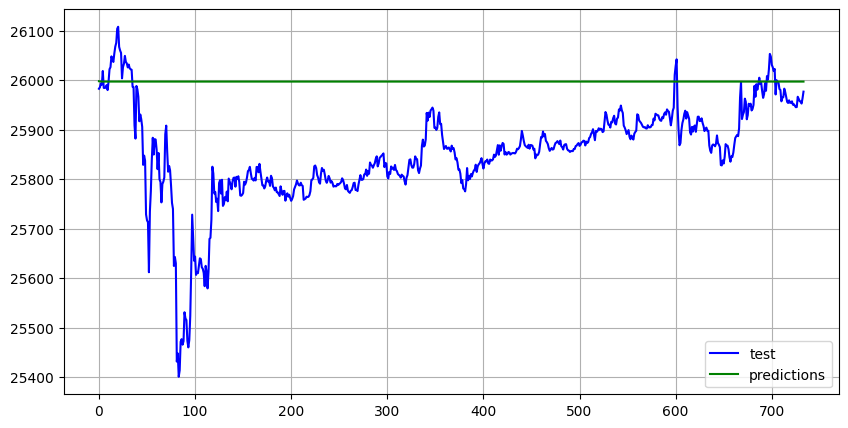

In [25]:
# Прогноз
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end)

plt.figure(figsize=(10, 5))
plt.plot(test.values, color = "blue", label="test")
plt.plot(predictions.values, color = "green", label="predictions")
plt.grid(True)
plt.legend()

Модель SARIMAX дает константное предсказание, попробуем подобрать параметры автоматически.

### SARIMAX с автопараметрами

Выбираем 𝑝,𝑞,𝑃,𝑄 минимизируя информационный критерий

Критерий Акаике  
AIC = Akaike Information Criterion
AIC = 2k - 2lnL  
Чем меньше AIC – тем точнее модель.

In [31]:
model_auto = auto_arima(train,
                        start_p = 0, start_q = 0,
                        max_p = 5, max_q = 5,
                        m = 1,
                        start_P = 0,
                        d=None, D = 0,
                        trace = True,
                        error_action ='ignore', suppress_warnings = True,  stepwise = True)
  
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39322.767, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39304.711, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39307.208, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39320.897, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39286.662, Time=0.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39288.655, Time=1.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39288.655, Time=1.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39294.161, Time=1.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=39290.655, Time=1.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=39284.756, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39302.825, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=39286.749, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=39286.749, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=39292.262, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4159
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -19639.378
Date:                Sun, 10 Sep 2023   AIC                          39284.756
Time:                        01:43:28   BIC                          39303.755
Sample:                             0   HQIC                         39291.477
                               - 4159                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0646      0.005     12.016      0.000       0.054       0.075
ar.L2          0.0696      0.004     16.070      0.000       0.061       0.078
sigma2       741.6030      2.731    271.573      0.000     736.251     746.955
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            904190.15
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             3.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        74.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Проверить
auto_arima(train,
                        start_p = 0, start_q = 0,
                        max_p = 5, max_q = 5,
                        m = 288,
                        start_P = 0,
                        d=None, D = 0,
                        trace = True,
                        error_action ='ignore', suppress_warnings = True,  stepwise = True)

In [ ]:
arima = SARIMAX(train, order = (2, 1, 0))
result = arima.fit()

start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end)

plt.figure(figsize=(10, 5))
plt.plot(test.values, color = "blue", label="test")
plt.plot(predictions.values, color = "green", label="predictions")
plt.grid(True)
plt.legend()

In [ ]:
# arima.plot_diagnostics(figsize=(10, 8))

Таким образом, модель ARIMA оказалась неспособной сделать удовлетворительный прогноз в отличие от линейной регрессии с лагами.

ARIMA с экзогенными переменными  
https://github.com/FUlyankin/matstat-AB/blob/main/week15_timeseries/data/hw15_arrriva.ipynb

### Теория  
1. [Видеолекция Е.Рябенко из МФТИ (youtube)](https://www.youtube.com/watch?v=u433nrxdf5k)  
2. [Статья Открытого курса машинного обучения (habr)](https://habr.com/ru/companies/ods/articles/327242/)  
3. [Курс "Временные ряды для прогноза криптовалют" от ФКН ВШЭ (stepik)](https://stepik.org/course/177216/syllabus)  
4. [Статья простым языком](https://www.dmitrymakarov.ru/intro/time-series-20/)